# Aircrew trainee scheduling with seniority constraints
[![tip8_aircrew_trainees_seniority.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/glebbelov/modeling-tips/tip8_aircrew_trainees_seniority.ipynb)](https://colab.ampl.com)

Description: Aircrew trainee scheduling with seniority constraints

Tags: trainee scheduling, aircrew scheduling, employee scheduling, seniority constraints, seniority ranking, amplpy

Notebook author: Gleb Belov <<gleb@ampl.com>>

References:
1. Kozanidis, G. (2017). Optimal assignment of aircrew trainees to simulator and classroom training sessions subject to seniority and preference restrictions. Journal of Air Transport Management 59, 143-154.
2. Gamache, M., Soumis, F., Villeneuve, D., Desrosiers, J., & Gélinas, É. (1998). The preferential bidding system at Air Canada. Transportation Science, 32(3), 246-255.
3. Achour, H., Gamache, M., Soumis, F., & Desaulniers, G. (2007). An exact solution approach for the preferential bidding system problem in the airline industry. Transportation Science, 41(3), 354-365.

In [1]:
# Install dependencies
%pip install -q amplpy pandas

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi", "xpress"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Mathematical model

This notebook considers a realistic trainee scheduling model from [1] involving classroom capacities, language and (reverse) seniority constraints, and seniority-ranked preferences. The (compulsory) seniority constraints are modeled by Preferential Bidding System (PBS)-style secondary objective functions.

**Sets:**
- $I$ - set of crew trainees,
- $T$ - set of training sessions,
- $V_i$ - set of valid sessions of trainee $i\in I$,
- $Pos$ - set of crew positions:  captain (CP), first officer (FO), purser (PU), or flight attendant (FA),
- $Grp$ - set of trainee groups: all, cockpit (CK), cabin (CB).

**Parameters:**
- $P_i\in Pos$ - position of trainee $i\in I$,
- $S_i$ - seniority. The smaller this number, the more senior the corresponding crew member,
- $E_i$ - flight capability expiration. 0: end of the current month, 1: end of the next month, 2: end of the next to the following month,
- $L_i$ - spoken language. 0: the trainee speaks both of the alternative languages, 1: only the first language, 2: only the second language,
- $Pr_{it}$ - priority of trainee $i$ for valid session $t$. Priorities are non-negative integers. Higher priorities mean higher preference. Zero priority means that the trainee does not want to be assigned to this session. All positive priorities for the same trainee should be different, while zero priority can be expressed for multiple sessions,
- $MAX_p$ - capacity of each training session for trainees of position $p\in Pos$,
- $MAX^+_g$ - capacity of each training session for trainees of group $g\in Grp$.

The aim is to find an optimal assignment of trainees to training sessions which minimizes the number of training slots that remain empty, while also satisfying a list of hard and soft requirements. The satisfaction of the hard restrictions is unnegotiable, whereas the soft ones must be satisfied to the greatest possible extent. The **hard restrictions** that must be satisfied are the following:
- Capacity constraints for each training session,
- One of the two alternative languages must be selected for each session,
- Every crew member with expiration 0 must be assigned to one of his/her valid sessions,
- Reverse expiration and reverse seniority restrictions. Suppose that there exists a slot in a training session, which is only valid to a specific subset of crew members, none of which has expressed positive preference for being assigned to this session. Since the minimization of the total number of empty slots is the model's primary objective, one of these crew members must eventually be assigned to this session. The reverse expiration restrictions, considered first, dictate that this should be the crew member with the lowest expiration (his/her flight capability should expire sooner) among them. Assume now, that two or more trainees have the lowest expiration. The reverse seniority restrictions, considered next, dictate that this should be the least senior trainee among all the trainees with the lowest expiration. Such restrictions can be called "expiration- and seniority-ranked anti-preferences".

Additionally, the following **soft restrictions** must be satisfied:
- The maximum possible preference satisfaction for each crew member must be attained, according to strict seniority. This means that no crew member's preference should be satisfied at the expense of the dissatisfaction of a more senior crew member's preference.
- The maximum possible preference satisfaction of each individual crew member must be attained, according to the list of priorities that he/she has expressed.

**Decision variables:**
- $x_{it}$ - binary decision variable, takes value $1$ *iff* trainee $i\in I$ is assigned to session $t\in V_t$,
- $y_i$ - binary decision variable that takes the value 1 *iff* trainee i remains unassigned, $i\in I$: $E_i = 1$ or $2$,
- $u_t$: binary decision variable that takes the value 1 if language 1 is selected for training session t, and 0 if language 2 is selected instead, $t\in T$,
- $w$: total number of crew trainees that remain unassigned.

The **optimization model**, formulated below in AMPL, follows [1], while differs as follows:
- The reverse expiration and seniority constraints ("anti-peferences") are sublimated via Preferential Bidding System (PBS)-style secondary objective functions. Minimizing the objective functions `ReverseSeniority[]` aims to approximate constraints (8), (9), (22-25), and (26--29) from [1], as well as resolve the 'pitfall' from Section 3.1.
- The lexicographic approach for (anti-)preference ranking by seniority is implemented via multiple objectives submitted to the solver in a single model.
No variables are fixed while optimizing the different objectives.

## Test instance generation

Define class `Instance` holding a problem instance.

In [3]:
class Instance:
    def __init__(self):
        ## Data arrays / matrices for all trainees
        self.nT = 0
        self.P = []
        self.S = []
        self.L = []
        self.E = []
        self.V = []
        self.Pr = []
        ## Capacity constraints
        self.cap_kind = []
        self.MAX = []
        self.cap_plus_kind = []
        self.cap_plus_which = []
        self.MAXPlus = []

Define class `InstGenParams` with instance generation parameters according to [1], but with a smaller ration of classes to trainees (originally 1/5.)

In [4]:
import math

class InstGenParams:
    def __init__(self, N):
        self.N = N
        self.T = math.ceil(N/13)    # Set lower to have non-assignments
        ## Ranges and probabilities
        self.position_kind = ["CP", "FO", "PU", "FA"]
        self.position_prob = [0.25, 0.25, 0.25, 0.25]
        self.language_prob = [0.5, 0.25, 0.25]
        self.expiration_prob = [0.5, 0.25, 0.25]
        self.N_sess_rng = [1, math.floor(self.T/2)]
        self.pref_0 = 0.5
        ## These are constant for all instances
        self.cap_kind = ["CP", "FO", "PU", "FA"]
        self.MAX = [4, 4, 4, 4]
        self.cap_plus_kind = ["All", "CK", "CB"]
        self.cap_plus_which = [[1, 2], [1, 2], [1, 3], [1, 3]]
        self.MAXPlus = [10, 6, 6]

Function to generate an instance.

In [5]:
import numpy as np
import pandas as pd

def GenInstance(genpar, rng):
    inst = Instance()
    inst.nT = genpar.T
    inst.S = np.arange(genpar.N)              # Seniority 0..N-1
    rng.shuffle(inst.S)
    for itr in range(0, genpar.N):
        inst.P.append(rng.choice(np.arange(1, len(genpar.position_prob)+1),  # 1-based
                                 p=genpar.position_prob))
        inst.L.append(rng.choice(len(genpar.language_prob), p=genpar.language_prob))
        inst.E.append(rng.choice(len(genpar.expiration_prob), p=genpar.expiration_prob))
        N_feas_sess = rng.integers(genpar.N_sess_rng[0], genpar.N_sess_rng[1]+1)
        V = rng.choice(np.arange(1, genpar.T+1),                   # 1-based
                       size=N_feas_sess, replace=False)
        inst.V.append( V )
        N_pr_0 = rng.binomial(N_feas_sess, genpar.pref_0)
        PrByV = np.concatenate( (np.zeros(N_pr_0), np.arange(1, N_feas_sess-N_pr_0+1)) )
        assert N_feas_sess == len(PrByV)
        rng.shuffle(PrByV)
        Pr = np.zeros(genpar.T)
        for k, t in enumerate(V):
            Pr[t-1] = PrByV[k]
        inst.Pr.append( Pr )
    # Capacities
    inst.cap_kind = genpar.cap_kind
    inst.MAX = genpar.MAX
    inst.cap_plus_kind = genpar.cap_plus_kind
    inst.cap_plus_which = genpar.cap_plus_which
    inst.MAXPlus = genpar.MAXPlus
    return inst

Generate instance.

In [6]:
rng = np.random.default_rng(122807528840384100672342137672332424406)

genpar = InstGenParams(200)             # With the Demo license, set up to 50
inst = GenInstance(genpar, rng)

## AMPL model

We start with the base part of the model. It is saved to file `airtrainee_base.mod`.

In [7]:
%%writefile airtrainee_base.mod

set I;              # Trainees
set T;              # Training sessions
set V{I} in T;      # Valid sessions for each trainee
set Pos;            # Positons
set PosPlus;        # Meta-positions (e.g, All, Cockpit, Cabin)
set MAXPlusWhich{Pos} in PosPlus;

param P{I} in Pos;  # Trainee's position
param S{I};         # Seniority (smaller value <=> higher seniority)
param L{I};         # Language (0 - both, 1 or 2 - one only)
param E{I};         # Expiration: 0 - this month, 1 - next month, 2 - in 2 months
param Pr{I, T};     # Priority: 0 - not wanted, larger value <=> higher preference
param MAX{Pos};     # Position capacity
param MAXPlus{PosPlus};  # Aggregated capacities (All, CK, CB)

var x{i in I, t in T} binary <= if t in V[i] then 1 else 0;
var y{i in I} binary <= if E[i]>0 then 1 else 0;      # Trainee i unassigned
var u{T} binary;    # 1 <=> language 1, 0 <=> language 2
var w >=0;          # Number of unassigned trainees

s.t. Assign_E0 {i in I: E[i]==0}:
  sum {t in V[i]} x[i, t] == 1;

s.t. Unassigned_E12 {i in I: E[i]>0}:
  sum {t in V[i]} x[i, t] + y[i] == 1;

s.t. Sum_Unassigned: w == sum {i in I: E[i]>0} y[i];

s.t. Language_1 {t in T}:
  u[t]<0.5 ==> sum {i in I: L[i]==1 and t in V[i]} x[i, t] <= 0;

s.t. Language_2 {t in T}:
  u[t]>=0.5 ==> sum {i in I: L[i]==2 and t in V[i]} x[i, t] <= 0;

s.t. Capacity {p in Pos, t in T}:
  sum {i in I: p==P[i] and t in V[i]} x[i, t] <= MAX[p];

s.t. Capacity_Meta {p in PosPlus, t in T}:
  sum {i in I: p in MAXPlusWhich[P[i]] and t in V[i]} x[i, t] <= MAXPlus[p];

suffix objpriority;
param S_range := max {i in I} S[i] - min {i in I} S[i];

# The primary objective
minimize Total_Unassigned: w suffix objpriority 3*S_range + 1;
# let Total_Unassigned.objpriority := card(I) + 3;

# Trainee preferences, ranked by seniority
set SenLevels := setof {i in I} S[i];
param prefMax {i in I} := max {t in V[i]} Pr[i, t];
minimize PrefViolRanked {s in SenLevels}:
  sum {i in I, t in T: s==S[i] and t in V[i]}
      ((prefMax[i] - Pr[i, t]) / max(prefMax[i], 1)           # Normalize
       * x[i, t])
    suffix objpriority max {j in I} S[j] + 2*S_range + 1 - s;

Overwriting airtrainee_base.mod


Next comes the new Reverse Seniority modeling as another set of lexicographically ranked PBS-style objective functions.

In [8]:
%%writefile airtrainee_seniority_reverse_PBS.mod

# Reverse seniority constraints,
# sublimated as post-processing objectives.
# Optimize for all trainees with E[i]==1, ranked by reverse seniority,
# then for all with E[i]==2.
# In this special case the objectives can be aggregated for each value of e
# (see Solve with aggregated preferences.)
maximize ReverseSeniority {e in 1..2, i in I}:
  sum {t in T: E[i]==e and t in V[i] and Pr[i, t]==0}
    S[i] * x[i, t]
    suffix objpriority (2-e)*S_range + 1 + S[i] - min {j in I} S[j];

Overwriting airtrainee_seniority_reverse_PBS.mod


Function to pass an instance to the AMPL model.

In [9]:
def MakeAMPLInstance(models, inst):
    ampl = AMPL()
    for mod in models:
        ampl.read(mod)
    # Fill data
    ampl.set["I"] = np.arange(1, len(inst.P)+1)
    ampl.set["T"] = np.arange(1, inst.nT+1)
    for i, vi in enumerate(inst.V):
        ampl.set["V"][i+1] = vi
    ampl.set["Pos"] = np.arange(1, len(genpar.position_prob)+1)
    ampl.set["PosPlus"] = np.arange(1, len(genpar.MAXPlus)+1)
    for i, vi in enumerate(inst.cap_plus_which):
        ampl.set["MAXPlusWhich"][i+1] = vi
    ampl.param["P"] = inst.P
    ampl.param["S"] = inst.S
    ampl.param["L"] = inst.L
    ampl.param["E"] = inst.E
    ampl.param["Pr"] = pd.DataFrame(data = inst.Pr,
                                    index = range(1, len(inst.P)+1),
                                    columns = range(1, inst.nT+1))
    ampl.param["MAX"] = inst.MAX
    ampl.param["MAXPlus"] = inst.MAXPlus
    
    return ampl

Function to check reverse seniority constraints according to [1].

See also `airtrainee_seniority_reverse_constraints.mod` below.

In [10]:
def CheckSenRev(ampl, inst):
    I = np.arange(len(inst.P))
    T = np.arange(inst.nT)
    V = [ { t-1 for t in Vi } for Vi in inst.V ]    # back to 0-based
    P = [ p-1 for p in inst.P ]
    S = inst.S
    L = inst.L
    E = inst.E
    Pr = inst.Pr
    MAX = inst.MAX
    MAXPlus = inst.MAXPlus
    # param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB
    GC = [ max(w)-1 for w in inst.cap_plus_which ]
    G = [GC[P[i]] for i in I]

    x = ampl.get_variable("x").get_values().to_pandas().unstack()
    y = [ 1 - x.iloc[i].sum(axis=0) for i in I ]   ## y[i]==1 means i not scheduled
    u = ampl.get_variable("u").get_values().to_pandas().unstack()
    nViol = 0
    result_msg = ""
    
    for e in range(1, 3):
        for i in I:
            for t in V[i]:
                if E[i]>0 and Pr[i][t]==0 \
                and round(y[i])==1 \
                and round(u.iloc[t])+1!=L[i]:     ## != means compatible language
                    JP = { j for j in I   ## Dominated trainees with same position
                          if (P[j]==P[i] and t in V[j] and Pr[j][t]==0 \
                              and ((E[j]==E[i] and S[j]<S[i]) or E[j]>E[i])) \
                         }
                    JG = { j for j in I   ## Dominated trainees in the same group but diff position
                          if (P[j]!=P[i] and G[j]==G[i] and t in V[j] and Pr[j][t]==0 \
                              and ((E[j]==E[i] and S[j]<S[i]) or E[j]>E[i])) \
                         }
                    JA = { j for j in I   ## Dominated trainees in the other group
                          if (G[j]!=G[i] and t in V[j] and Pr[j][t]==0 \
                              and ((E[j]==E[i] and S[j]<S[i]) or E[j]>E[i])) \
                         }
                    ## Now: dominating sets
                    DJP = { j for j in I   ## Dominating trainees with same position
                           if (P[j]==P[i] and t in V[j] \
                               and (E[j]==0 or \
                                    (E[j]==E[i] and (S[j]>S[i] or Pr[j][t]>0)) or \
                                    (E[j]>E[i] and Pr[j][t]>0))) \
                         }
                    DJG = { j for j in I   ## Dominating trainees in the same group
                           if (G[j]==G[i] and t in V[j] \
                               and (E[j]==0 or \
                                    (E[j]==E[i] and (S[j]>S[i] or Pr[j][t]>0)) or \
                                    (E[j]>E[i] and Pr[j][t]>0))) \
                         }
                    z_it = round( sum([ x.iloc[j, t] for j in DJP ]) ) >= MAX[P[i]]
                    u2_it = round( sum([ x.iloc[j, t] for j in DJG ]) ) >= MAXPlus[G[i]]
                    setU = [JP, JG, JA]
                    setD = [[], [DJP], [DJP, DJG]]
                    flgD = [[], [z_it], [z_it, u2_it]]
                    for iDom in range(3):
                        if round( sum( [ x.iloc[j, t] for j in setU[iDom] ] ) ) >= 1 \
                        and (len(flgD[iDom])==0 or max( flgD[iDom] )==0):
                            nViol += 1
                            # result_msg = result_msg + \
                            # "\n    RevSen VIOLATION: kind={}, [i, t]=[{}, {}], J={}, DJ={}, flgD={}" \
                            # .format(iDom+1, i, t, setU[iDom], setD[iDom], flgD[iDom])

    result_msg = result_msg + str(nViol) + " original reverse seniority violations (with language compatibility)."
    return nViol==0, result_msg

Function to display solution characteristics.

In [11]:
import matplotlib.pyplot as plt 
  
def PresentSolution(ampl, inst):
    prefs = ampl.get_objective("PrefViolRanked").get_values().to_pandas()
    prefViolAve = prefs.sum().sum()/len(prefs.index)
    print("AVERAGE NORMALIZED PREFERENCE VIOLATION = {:.4}".format(prefViolAve))
    # Seniority as objectives
    print("REVERSE SENIORITY:")
    print("   ---- AS PBS OBJECTIVES:")
    ampl.eval(
        """
        display {e in 1..2}
          sum {i in I, t in T: E[i]==e and t in V[i] and Pr[i, t]==0}
            S[i] * x[i, t];
        """
    )
    x = ampl.get_variable("x").get_values().to_pandas().unstack().T
    status, msg = CheckSenRev(ampl, inst)
    print("   ---- AS DOMINANCE CONSTRAINTS FROM [1]: {}; {}".format(status, msg))
    print("AVERAGE SESSION LOAD IMBALANCE = {:.3}\n".format(
        float( ampl.get_value(
            "sum {t in T} abs( sum {i in I: t in V[i]} x[i, t] - sum {i in I, t1 in V[i]} x[i, t1] / card(T) ) / card(T)"))))
    for obj in ampl.get_objectives():
        print("{:20} = {}".format(obj[0], obj[1].get_values().to_pandas().T))
    # Preferences
    plot = prefs.plot(title="Ranked normalized preference violations", xlabel="Seniority")
    plot.hlines(prefViolAve, 0, len(prefs.index), label="Average", linestyle='--', color='pink')
    plt.legend(('PrefViolRanked', 'Average'))
    plt.show()
    # Solution as a heat map
    plt.imshow( x )
    plt.title( "Schedule" )
    plt.xlabel( "Trainees" )
    plt.ylabel( "Classes" )
    plt.show()
    # Free capacity
    cap = ampl.get_data("Capacity.slack").to_pandas().unstack().T
    cap.columns = inst.cap_kind
    cap.index = np.arange(1, inst.nT+1)
    plot = cap.plot(title="Free capacity by position", xlabel="Class slot", kind="bar", stacked=True)
    plt.show()
    # Free group capacity
    cap = ampl.get_data("Capacity_Meta.slack").to_pandas().unstack().T
    cap.columns = inst.cap_plus_kind
    cap.index = np.arange(1, inst.nT+1)
    plot = cap.plot(title="Free group capacity", xlabel="Class slot", kind="bar", stacked=True)
    plt.show()
    # Session language
    print("Session language")
    print(ampl.get_variable("u").get_values().to_pandas().T)
    assert 1==min(ampl.get_data("Language_1").to_pandas().T)      # Minimal value of the logical constraints (1 when all true)
    assert 1==min(ampl.get_data("Language_2").to_pandas().T)

## Experiment

We start with the new model in several modifications, then compare it to the original model from [1].

### Solve with ranked preferences

To solve with properly ranked preferences as in [1], we submit the model as-is. The solver uses the `.objpriority` suffixes for ranking.

In [12]:
ampl = MakeAMPLInstance(["airtrainee_base.mod", "airtrainee_seniority_reverse_PBS.mod"], inst)

ampl.export_data("airtrainee.dat")
## ampl.eval("s.t. Fix1: x[67, 5]==1;")
ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1", verbose=False)

Solve result = solved, time: 0.492s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.1172
REVERSE SENIORITY:
   ---- AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  662
2  989
;

   ---- AS DOMINANCE CONSTRAINTS FROM [1]: False; 38 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                 0    1    2    3    4    5    6    7    8    9    ...  190  \
PrefViolRanked  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                191  192  193  194  195  196  197  198  199  
PrefViolRanked  0.0  0.8  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 200 columns]
ReverseSeniority     = index0             1                                      ...   2              \
index1           1   2   3   4   5   6   7   8   9   10   ... 191 192 193 194   
ReverseSeniority   0   0   0   0   0   0   0   0   0   0  ...   0 

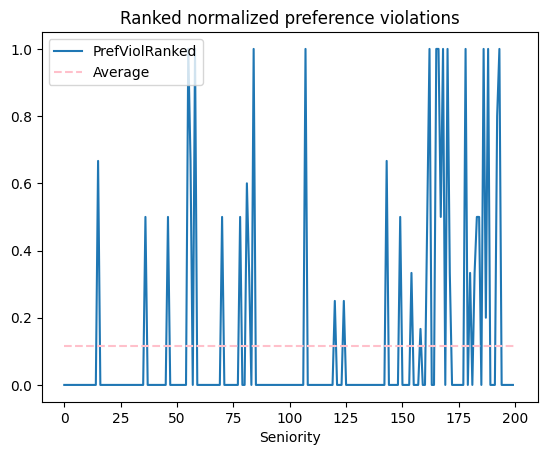

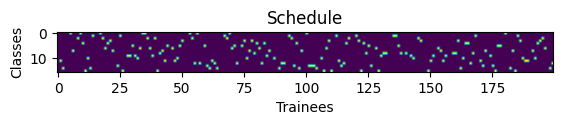

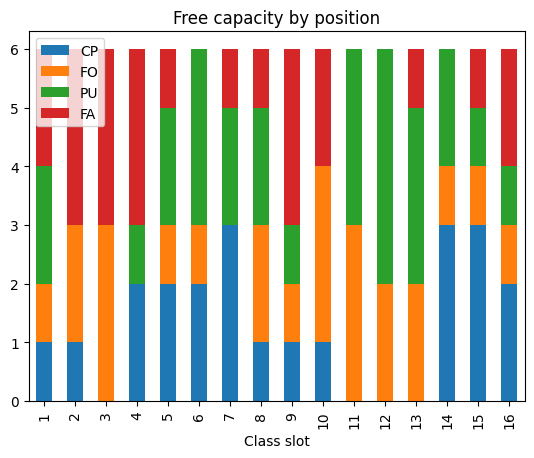

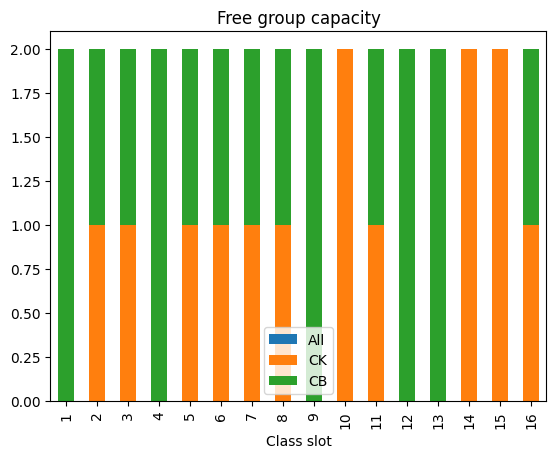

Session language
       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
u.val   1   1   0   0   1   0   0   1   0   1   0   0   0   0   1   1


In [13]:
print("Solve result = {}, time: {:.3}s\n--------------------------------".format(ampl.solve_result, ampl.get_value("Initial.time")))
PresentSolution(ampl, inst)

### Solve with averaged preferences

To reduce the average preference violation and improve average "anti-preference", we could sacrifice strict seniority ranking
and minimize the total violation in one go. For this we assign equal
`.objpriority` suffixes for the `PrefViolRanked` and `ReverseSeniority` objectives. In practice, the sum can
be weighted to keep seniority aspirations, for example by the `.objweight` suffixes.

In [14]:
ampl.eval("let {s in SenLevels} PrefViolRanked[s].objpriority := 3;")
ampl.eval("let {e in 1..2, i in I} ReverseSeniority[e, i].objpriority := 3-e;")

ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1", verbose=False)

Solve result = solved, time: 0.0636s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.0855
REVERSE SENIORITY:
   ---- AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  496
2  796
;

   ---- AS DOMINANCE CONSTRAINTS FROM [1]: False; 42 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                 0    1    2    3    4    5    6    7    8    9    ...  190  \
PrefViolRanked  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                191  192  193  194  195  196  197  198  199  
PrefViolRanked  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 200 columns]
ReverseSeniority     = index0             1                                      ...   2              \
index1           1   2   3   4   5   6   7   8   9   10   ... 191 192 193 194   
ReverseSeniority   0   0   0   0   0   0   0   0   0   0  ...   0

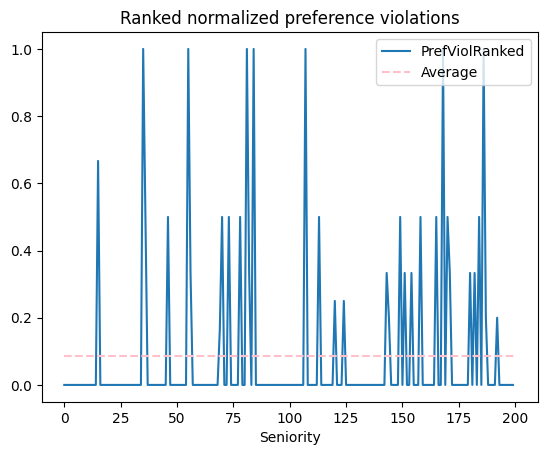

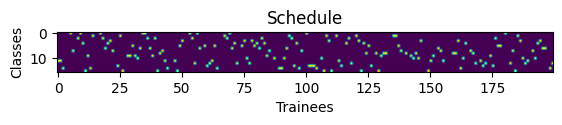

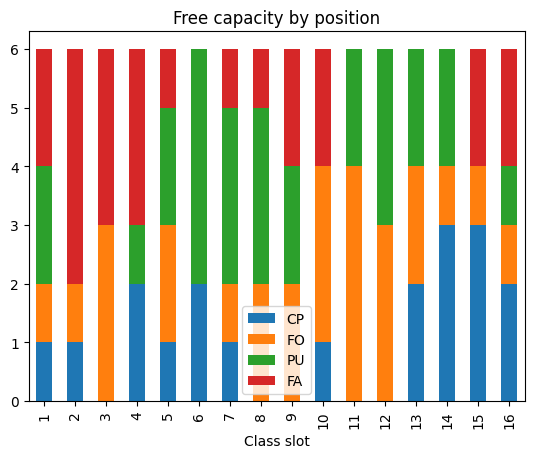

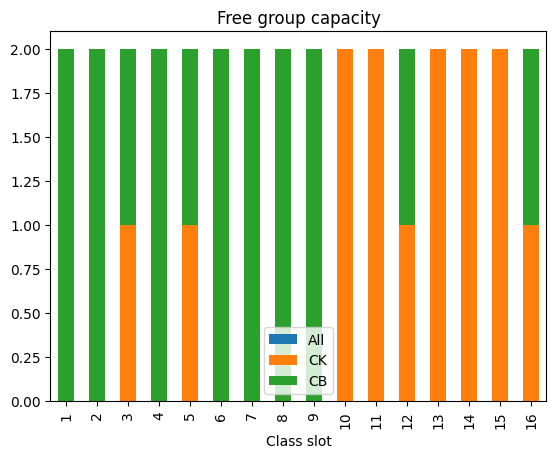

Session language
       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
u.val   1   1   0   0   1   0   0   1   0   1   0   0   1   0   1   1


In [15]:
print("Solve result = {}, time: {:.3}s\n--------------------------------".format(ampl.solve_result, ampl.get_value("Initial.time")))
PresentSolution(ampl, inst)

### Solve minimizing session load imbalance

Similar to the last model extension in [1], we post-process the solution
to minimize session load imbalance. We only tackle the imbalance in overall class loads.
For that we add yet another objective function.

In [16]:
%%writefile airtrainee_load_balancing.mod

# Minimize overall session load imbalance
minimize LoadImbalance:
  sum {t in T} abs( sum {i in I: t in V[i]} x[i, t] - sum {i in I, t1 in V[i]} x[i, t1] / card(T) )
  suffix objpriority 0;

Overwriting airtrainee_load_balancing.mod


In [17]:
ampl.read("airtrainee_load_balancing.mod")
ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1", verbose=False)

Solve result = solved, time: 0.173s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.0855
REVERSE SENIORITY:
   ---- AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  496
2  796
;

   ---- AS DOMINANCE CONSTRAINTS FROM [1]: False; 42 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

LoadImbalance        =                0
LoadImbalance  0
PrefViolRanked       =                 0    1    2    3    4    5    6    7    8    9    ...  190  \
PrefViolRanked  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                191  192  193  194  195  196  197  198  199  
PrefViolRanked  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 200 columns]
ReverseSeniority     = index0             1                                      ...   2              \
index1           1   2   3   4   5   6   7   8   9   10   ... 191 192 193 194   
ReverseSe

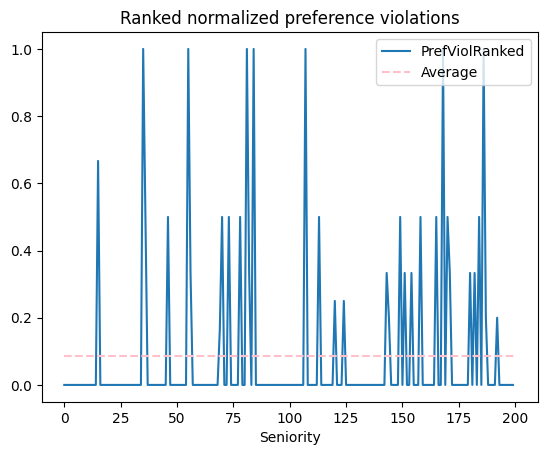

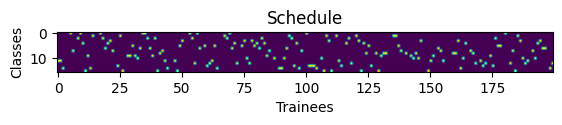

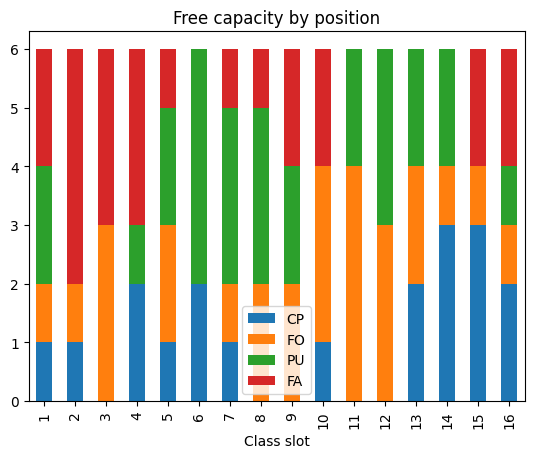

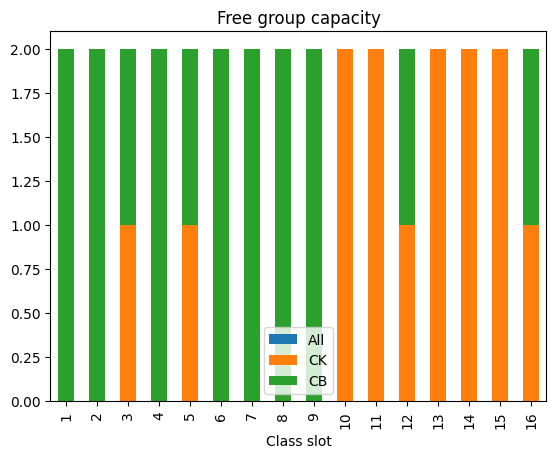

Session language
       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
u.val   1   1   0   0   1   0   0   1   0   1   0   0   1   0   1   1


In [18]:
print("Solve result = {}, time: {:.3}s\n--------------------------------".format(ampl.solve_result, ampl.get_value("Initial.time")))
PresentSolution(ampl, inst)

### The original modeling of reverse seniority

The model in [1] explicitly constrains reverse seniority using $O( |I| |T|)$ additional variables and inequalities, as follows.

In [19]:
%%writefile airtrainee_seniority_reverse_constraints.mod

# Enforce that trainees with expiration E[i]==1 month
# and slot priority Pr[i, t]==0 (don't want this slot)
# and the same position P[i]
# are chosen with the smallest seniority for a given slot,
# and preferred to those with expiration E[i]==2.
s.t. ConOrig_8 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  y[i]>=0.5 ==>
    sum {j in I: E[j]==1 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Similar dominance among those with E[i]==2.
s.t. ConOrig_9 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  y[i]>=0.5 ==>
    sum {j in I: E[j]==2 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Auxiliary variables for more dominance relations
var z {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
var u2 {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;

param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB

# Dominance to the other position in the same group.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_23.)
# Constraints (22)-(25) are an extension of (8).
s.t. ConOrig_22 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  (z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==1 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    + sum {j in I: E[j]==2 && P[j]!=P[i]
           && G[j]==G[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==1
s.t. ConOrig_23 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAX[P[i]];

# Dominance to the other group.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_25.)
s.t. ConOrig_24 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  (u2[i, t]<0.5 && z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==1 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
    + sum {j in I: E[j]==2 && G[j]!=G[i]
           && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain u2 for E[i]==1
s.t. ConOrig_25 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && G[j]==G[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[G[i]];

## The below constraints (26)-(29) are an extension of (9),
## similar to (22)-(25).
# Dominance to the other position in the same group for E[i]==2.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_27.)
s.t. ConOrig_26 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  (z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==2 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==2
s.t. ConOrig_27 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    >= MAX[P[i]];

# Dominance to the other group for E[i]==2.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_29.)
s.t. ConOrig_28 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  (u2[i, t]<0.5 && z[i, t]<0.5 && y[i]>=0.5) ==>
    sum {j in I: E[j]==2 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain u2 for E[i]==2
s.t. ConOrig_29 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    >= MAXPlus[G[i]];

Overwriting airtrainee_seniority_reverse_constraints.mod


Solve the old model from scratch.

In [20]:
ampl = MakeAMPLInstance(["airtrainee_base.mod", "airtrainee_seniority_reverse_constraints.mod", "airtrainee_seniority_reverse_PBS.mod"], inst)

ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1", verbose=False)

Solve result = solved, time: 1.97s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.1505
REVERSE SENIORITY:
   ---- AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  802
2  193
;

   ---- AS DOMINANCE CONSTRAINTS FROM [1]: True; 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                 0    1    2    3    4    5    6    7    8    9    ...  190  \
PrefViolRanked  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                191  192  193  194  195  196  197       198  199  
PrefViolRanked  0.0  0.8  1.0  0.0  0.0  0.0  1.0  0.333333  0.0  

[1 rows x 200 columns]
ReverseSeniority     = index0             1                                      ...   2              \
index1           1   2   3   4   5   6   7   8   9   10   ... 191 192 193 194   
ReverseSeniority   0   0   0   0   0   0   0   0   0   0  .

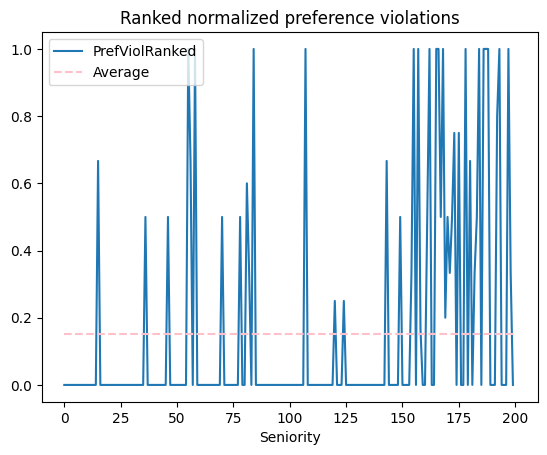

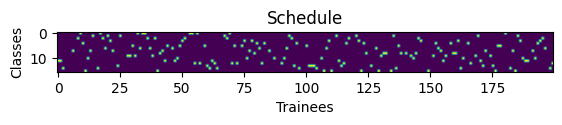

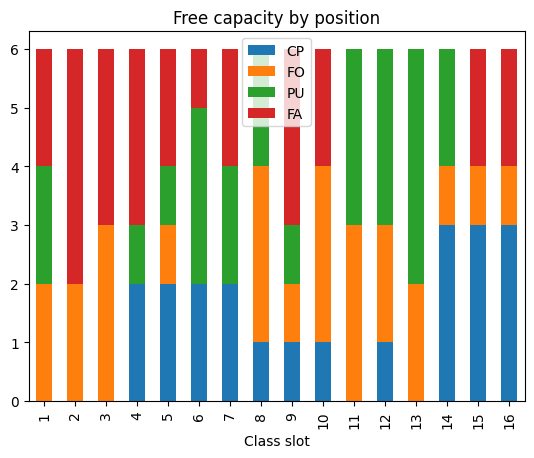

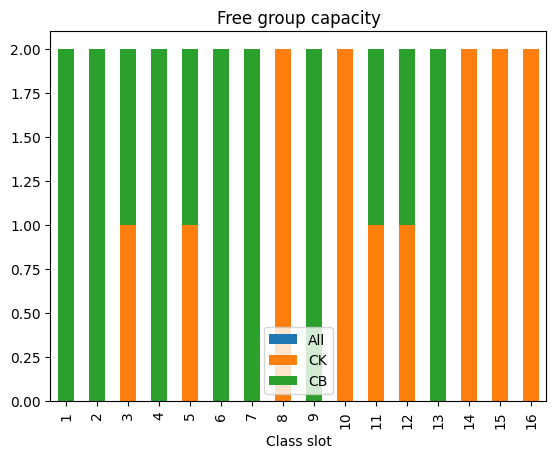

Session language
       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
u.val   1   1   0   0   1   0   0   1   0   1   0   0   0   0   1   1


In [21]:
print("Solve result = {}, time: {:.3}s\n--------------------------------".format(ampl.solve_result, ampl.get_value("Initial.time")))
PresentSolution(ampl, inst)

### Updated original constraints: language compatibility

We see that the explicit reverse seniority constraints increase the preference violation, compared to the new model. Let us modify the constraints to consider language assignments, and not require seniority dominance when it cannot be satisfied due to incompatible languages.

In [22]:
%%writefile airtrainee_seniority_reverse_constraints_language.mod

# Enforce that trainees with expiration E[i]==1 month
# and slot priority Pr[i, t]==0 (don't want this slot)
# and the same position P[i]
# are chosen with the smallest seniority for a given slot,
# and preferred to those with expiration E[i]==2.
# Consider language compatibility.
s.t. ConOrig_8 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Similar dominance among those with E[i]==2.
s.t. ConOrig_9 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Auxiliary variables for more dominance relations
var z {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
var u2 {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;

param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB

# Dominance to the other position in the same group.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_23.)
# Constraints (22)-(25) are an extension of (8).
s.t. ConOrig_22 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 || y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]!=P[i]
           && G[j]==G[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain z for E[i]==1
s.t. ConOrig_23 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAX[P[i]];

# Dominance to the other group.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_25.)
s.t. ConOrig_24 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && G[j]!=G[i]
           && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==1
s.t. ConOrig_25 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && G[j]==G[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[G[i]];

## The below constraints (26)-(29) are an extension of (9),
## similar to (22)-(25).
# Dominance to the other position in the same group for E[i]==2.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_27.)
s.t. ConOrig_26 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 || y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==2
s.t. ConOrig_27 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    >= MAX[P[i]];

# Dominance to the other group for E[i]==2.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_29.)
s.t. ConOrig_28 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==2
s.t. ConOrig_29 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    >= MAXPlus[G[i]];

Overwriting airtrainee_seniority_reverse_constraints_language.mod


In [23]:
ampl = MakeAMPLInstance(["airtrainee_base.mod", "airtrainee_seniority_reverse_constraints_language.mod", "airtrainee_seniority_reverse_PBS.mod"], inst)

ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1", verbose=False)

Solve result = solved, time: 1.82s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.1505
REVERSE SENIORITY:
   ---- AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  802
2  193
;

   ---- AS DOMINANCE CONSTRAINTS FROM [1]: True; 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                 0    1    2    3    4    5    6    7    8    9    ...  190  \
PrefViolRanked  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                191  192  193  194  195  196  197       198  199  
PrefViolRanked  0.0  0.8  1.0  0.0  0.0  0.0  1.0  0.333333  0.0  

[1 rows x 200 columns]
ReverseSeniority     = index0             1                                      ...   2              \
index1           1   2   3   4   5   6   7   8   9   10   ... 191 192 193 194   
ReverseSeniority   0   0   0   0   0   0   0   0   0   0  .

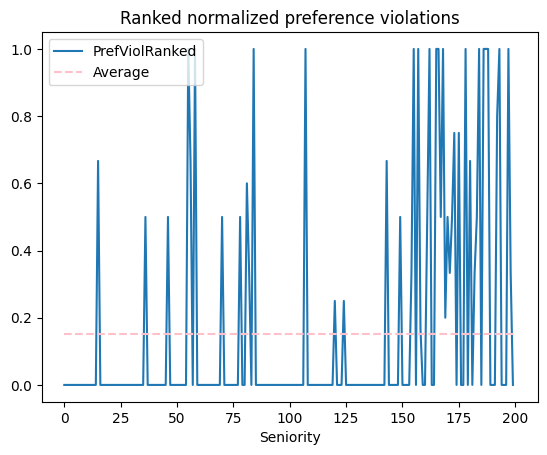

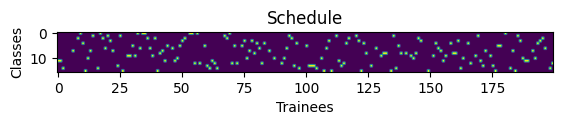

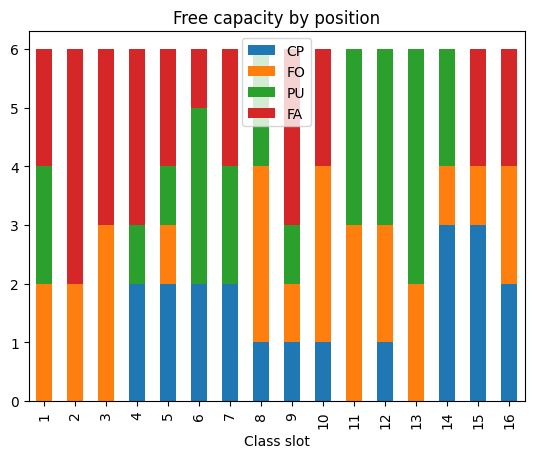

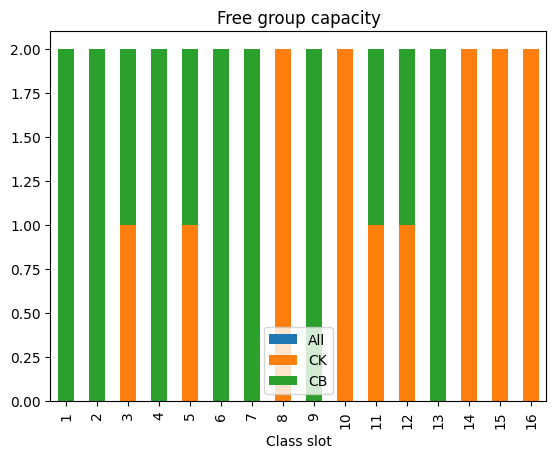

Session language
       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
u.val   1   1   0   0   1   0   0   1   0   1   0   0   0   0   1   1


In [24]:
print("Solve result = {}, time: {:.3}s\n--------------------------------".format(ampl.solve_result, ampl.get_value("Initial.time")))
PresentSolution(ampl, inst)

### Update 2: consider all capacities

The preference violation is still larger than in the new model. We notice that this might be due to other capacity constraints (group, total) not considered in ConOrig_22, _24, _26, _28 (via ConOrig_23 etc.) For that we introduce variable `zz` implying full total capacity for a slot.

In [25]:
%%writefile airtrainee_seniority_reverse_constraints_language_fullcapacity.mod

# Enforce that trainees with expiration E[i]==1 month
# and slot priority Pr[i, t]==0 (don't want this slot)
# and the same position P[i]
# are chosen with the smallest seniority for a given slot,
# and preferred to those with expiration E[i]==2.
# Update 1: consider language compatibility.
s.t. ConOrig_8 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Similar dominance among those with E[i]==2.
s.t. ConOrig_9 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  y[i]<0.5 || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]==P[i] && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Auxiliary variables for more dominance relations
var z {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
var u2 {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;
# Update 2: having full total class capacity.
var zz {i in I, t in T} binary <= if t in V[i] && E[i]>0 && Pr[i, t]==0 then 1 else 0;

param G {i in I} := max {pp in MAXPlusWhich[P[i]]} pp;      # Group: CK or CB

# Dominance to the other position in the same group.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_23.)
# Constraints (22)-(25) are an extension of (8).
# Update 2: consider group and total class capacities.
s.t. ConOrig_22 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && P[j]!=P[i]
           && G[j]==G[i] && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain z for E[i]==1
s.t. ConOrig_23 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && P[j]==P[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAX[P[i]];

# Dominance to the other group.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_25.)
s.t. ConOrig_24 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==1 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        + sum {j in I: E[j]==2 && G[j]!=G[i]
           && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==1
s.t. ConOrig_25 {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && G[j]==G[i] && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[G[i]];

s.t. ConOrig_25_ZZ {i in I, t in V[i]: E[i]==1 && Pr[i, t]==0}:
  zz[i, t]>=0.5 ==>
    sum {j in I: E[j]==0 && t in V[j]} x[j, t]
    + sum {j in I: E[j]==1 && (S[j]>S[i] || Pr[j, t]==0) && t in V[j] } x[j, t]
    + sum {j in I: E[j]==2 && t in V[j] && Pr[j, t]>0} x[j, t]
    >= MAXPlus[1];

## The below constraints (26)-(29) are an extension of (9),
## similar to (22)-(25).
# Dominance to the other position in the same group for E[i]==2.
# Only necessary when z[i, t]==0 which means that there are free
# higher-priority places for this position (see ConOrig_27.)
s.t. ConOrig_26 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && P[j]!=P[i]
         && G[j]==G[i]      # Same group
         && t in V[j] && Pr[j, t]==0} x[j, t]
    <= 0;

# Constrain z for E[i]==2
s.t. ConOrig_27 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  z[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && P[j]==P[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && P[j]==P[i] && t in V[j] } x[j, t]
    >= MAX[P[i]];

# Dominance to the other group for E[i]==2.
# Only necessary when z[i, t]==0 and u2[i, t] which means that there are free
# higher-priority places for this position and group (see ConOrig_29.)
s.t. ConOrig_28 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  zz[i, t]>=0.5 || u2[i, t]>=0.5 || z[i, t]>=0.5 || y[i]<0.5
    || (if L[i]>0 then u[t]==L[i]-1)
    || sum {j in I: E[j]==2 && S[j]<S[i] && G[j]!=G[i]
         && t in V[j] && Pr[j, t]==0} x[j, t]
        <= 0;

# Constrain u2 for E[i]==2
s.t. ConOrig_29 {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  u2[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && G[j]==G[i] && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && G[j]==G[i] && t in V[j] } x[j, t]
    >= MAXPlus[G[i]];

s.t. ConOrig_29_ZZ {i in I, t in V[i]: E[i]==2 && Pr[i, t]==0}:
  zz[i, t]>=0.5 ==>
    sum {j in I: E[j]<2 && t in V[j]} x[j, t]
    + sum {j in I: E[j]==2 && (S[j]>S[i] || Pr[j, t]==0) && t in V[j] } x[j, t]
    >= MAXPlus[1];

Overwriting airtrainee_seniority_reverse_constraints_language_fullcapacity.mod


In [26]:
ampl = MakeAMPLInstance(["airtrainee_base.mod", "airtrainee_seniority_reverse_constraints_language_fullcapacity.mod", "airtrainee_seniority_reverse_PBS.mod"], inst)

ampl.solve(solver="gurobi", gurobi_options="outlev=0 iis=1 multiobj=1 tech:timing=1", verbose=False)

Solve result = solved, time: 2.67s
--------------------------------
AVERAGE NORMALIZED PREFERENCE VIOLATION = 0.1505
REVERSE SENIORITY:
   ---- AS PBS OBJECTIVES:
sum{i in I, t in T: E[i] == e && t in  V[i] && Pr[i,t] == 0} S[i]*x[i,t] [*] :=
1  802
2  193
;

   ---- AS DOMINANCE CONSTRAINTS FROM [1]: True; 0 original reverse seniority violations (with language compatibility).
AVERAGE SESSION LOAD IMBALANCE = 0.0

PrefViolRanked       =                 0    1    2    3    4    5    6    7    8    9    ...  190  \
PrefViolRanked  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                191  192  193  194  195  196  197       198  199  
PrefViolRanked  0.0  0.8  1.0  0.0  0.0  0.0  1.0  0.333333  0.0  

[1 rows x 200 columns]
ReverseSeniority     = index0             1                                      ...   2              \
index1           1   2   3   4   5   6   7   8   9   10   ... 191 192 193 194   
ReverseSeniority   0   0   0   0   0   0   0   0   0   0  .

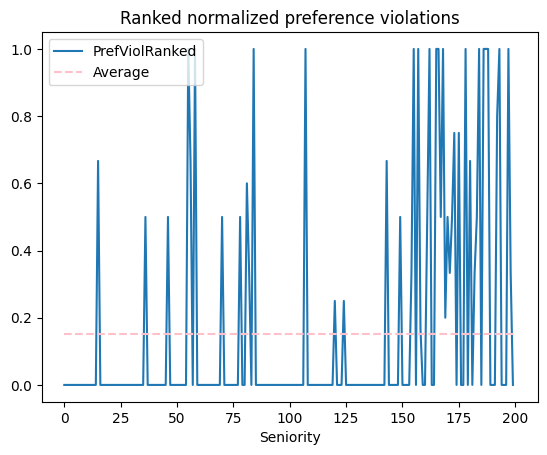

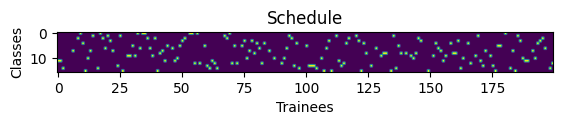

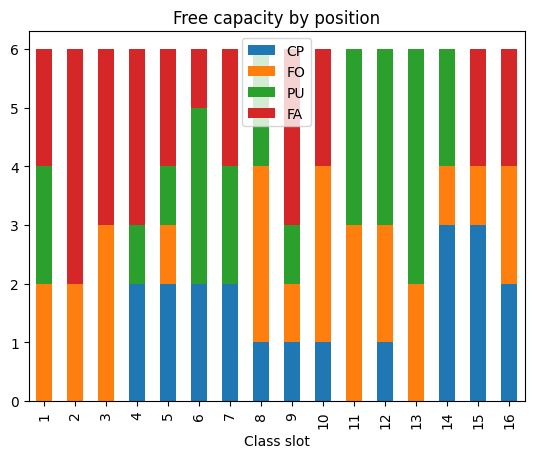

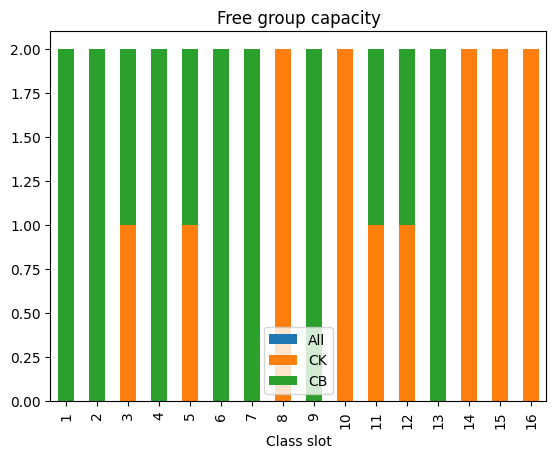

Session language
       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
u.val   1   1   0   0   1   0   0   1   0   1   0   0   0   0   1   1


In [27]:
print("Solve result = {}, time: {:.3}s\n--------------------------------".format(ampl.solve_result, ampl.get_value("Initial.time")))
PresentSolution(ampl, inst)

## Conclusions

We studied an aircrew trainee scheduling problem from [1] with seniority-ranked preferences and seniority- and expiration-ranked "anti-preferences" for class assignments. We proposed a Priority Bidding System-style modeling for the "anti-preferences" part. It offers greater satisfaction for both the preferences and "anti-preferences" parts of the problem and seems to resolve a 'pitfall' described in [1]. The new approach is simpler to model (lexicographic auxiliary objective functions) and more efficient to solve. Even for the original model from [1], solving times have been greatly improved by using Gurobi's multi-objective capability.

At the same time, the new approach does not strictly satisfy all the "anti-preference" constraints, in certain sense aggregating them among the trainees.